In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load subscription data into a Pandas DataFrame
sub_data = pd.read_csv('data/customer_product.csv').drop(['Unnamed: 0'], axis=1)
sub_data.head()

,customer_id,product,signup_date_time,cancel_date_time
0,C2448,prd_1,2017-01-01 10:35:09,NaN
1,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02
2,C2450,prd_1,2017-01-01 11:42:00,2019-01-13 16:24:55
3,C2451,prd_2,2017-01-01 13:32:08,NaN
4,C2452,prd_1,2017-01-01 13:57:30,2021-06-28 18:06:01


In [3]:
# Reducing data to those who have cancelled
cancels_df = sub_data.copy()
cancels_df = cancels_df[~cancels_df['cancel_date_time'].isna()]

In [4]:
def decompose_date(df, s, prefix='', include_time=True):
    '''
    given a pd df and series, break out the series column to year, month, day, hour, min, sec
    Returns updated dataframe with added fields
    '''
    # TODO: add assertion rule for datetime

    df_out = df.copy()
    df_out[f'{prefix}year'] = df[s].dt.year
    df_out[f'{prefix}month'] = df[s].dt.month
    df_out[f'{prefix}day'] = df[s].dt.day

    if include_time:
        # TODO: assertion to confirm there is time in the date field
        df_out[f'{prefix}hour'] = df[s].dt.hour
        df_out[f'{prefix}minute'] = df[s].dt.minute
        df_out[f'{prefix}second'] = df[s].dt.second

    return df_out

In [5]:
# Convert sign-up and cancel dates to datetime format
cancels_df['signup_date_time'] = pd.to_datetime(cancels_df['signup_date_time'])
cancels_df['cancel_date_time'] = pd.to_datetime(cancels_df['cancel_date_time'])

# Create a new column to calculate subscription length in months
cancels_df['subscription_length'] = ((cancels_df['cancel_date_time'] - cancels_df['signup_date_time']) / pd.Timedelta(days=30)).astype(int)
cdf1 = decompose_date(cancels_df, 'signup_date_time', 'signup_')
cdf2 = decompose_date(cdf1, 'cancel_date_time', 'cancel_')

# add dates without time
cdf2['signup_date'] = cdf2['signup_date_time'].dt.strftime('%Y-%m-%d')
cdf2['cancel_date'] = cdf2['cancel_date_time'].dt.strftime('%Y-%m-%d')

In [6]:
# Metrics
print(f"Year with the most signups = {cdf2['signup_year'].mode().values[0]}")
print(f"Top Signup Month = {cdf2['signup_month'].mode().values[0]}")
print('')
print(f"Year with the most Cancellations = {cdf2['cancel_year'].mode().values[0]}")
print(f"Top Cancel Month = {cdf2['cancel_month'].mode().values[0]}")



Year with the most signups = 2019
Top Signup Month = 1

Year with the most Cancellations = 2021
Top Cancel Month = 12


### Visualize the Time Series by Product

- Is there an obvious trend, seasonality effects, or clear residuals?

In [7]:
# Group data by signup date and count
dfnew = cdf2.copy()

signups_by_day = dfnew.groupby(['signup_date', 'product'])['customer_id'].count().reset_index()
signups_by_day = signups_by_day.sort_values('signup_date').reset_index(drop=True)
signups_by_day.columns = ['signup_date', 'product', 'signup_count']


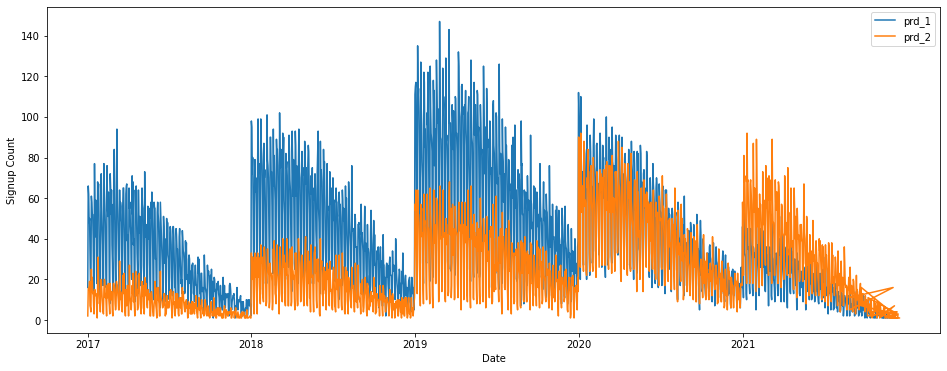

In [8]:
# Plot subscription counts by product type and length
fig, ax = plt.subplots(figsize=(16,6))
for product in signups_by_day['product'].unique():
    prod_data = signups_by_day[signups_by_day['product'] == product]
    ax.plot(prod_data['signup_date'], prod_data['signup_count'], label=product)

ax.legend()
ax.set_xticks(
    ['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'],
    ['2017', '2018', '2019', '2020', '2021']
)
ax.set_ylabel('Signup Count')
ax.set_xlabel('Date')
plt.show()

### How Long do customers subscribe excluding those who have not cancelled

In [9]:
# get subscription metrics
print(f"Mean subscription length in months = {cancels_df['subscription_length'].mean()}")
print(f"-- Product 1 Mean Sub Length = {cancels_df[cancels_df['product'] == 'prd_1']['subscription_length'].mean()}")
print(f"-- Product 2 Mean Sub Length = {cancels_df[cancels_df['product'] == 'prd_2']['subscription_length'].mean()}")

Mean subscription length in months = 14.822038494021426
-- Product 1 Mean Sub Length = 16.34396257283086
-- Product 2 Mean Sub Length = 12.344391748241947


In [10]:
# Group subscriptions by product type and subscription length
sub_by_prod = cancels_df.groupby(['product', 'subscription_length']).count().reset_index()

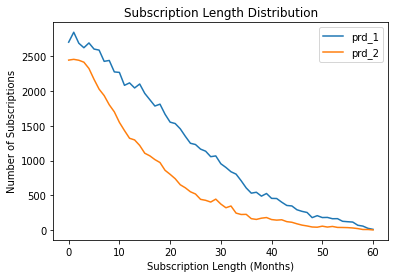

In [11]:
# Plot subscription counts by product type and length
fig, ax = plt.subplots()
for product in sub_by_prod['product'].unique():
    prod_data = sub_by_prod[sub_by_prod['product'] == product]
    ax.plot(prod_data['subscription_length'], prod_data['customer_id'], label=product)
ax.legend()
ax.set_title('Subscription Length Distribution')
ax.set_xlabel('Subscription Length (Months)')
ax.set_ylabel('Number of Subscriptions')
plt.show()